In [1]:
import os
import sys


import numpy as np
import pandas as pd
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

In [5]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

from src.mol_feats import (
    Morgan_f
)

from src.prot_feats import (
    BeplerBerger_DSCRIPT_cat_f,
    ESM_DSCRIPT_cat_f,
    ProtBert_DSCRIPT_cat_f
)

from src.architectures import SimpleCosine

---

In [8]:
# df = pd.read_csv('dataset/DAVIS/test.csv',index_col=0)
df = pd.read_csv(f'{BASE_DIR}/dataset/BindingDB/test.csv',index_col=0)

In [9]:
device = 5
torch.cuda.set_device(device)

In [10]:
prot_feat = ESM_DSCRIPT_cat_f()
mol_feat = Morgan_f()

In [46]:
baseline_mol = torch.zeros((1,mol_feat._size)).cuda()
baseline_prot = torch.zeros((1,prot_feat._size)).cuda()

In [11]:
# model = torch.load(f'{MODEL_BASE_DIR}/Davis_SimpleCosine_Morgan_ProtBert_DSCRIPT_cat_rep0_best_model.sav').to(device).eval()
model = torch.load(f'/afs/csail.mit.edu/u/s/samsl/Work/Applications/MolTrans/Davis_SimpleCosine_Morgan_ProtBert_DSCRIPT_cat_rep0_best_model.sav').to(device).eval()

ModuleNotFoundError: No module named 'attendti'

In [35]:
df

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CN(C)CC1CCN2C=C(C3=CC=CC=C32)C4=C(C5=CN(CCO1)C...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,[0. 0. 0. ... 0. 0. 0.],[8.483 5.827 3.599 ... 0. 0. 0. ]
1,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,MAEKQKHDGRVKIGHYVLGDTLGVGTFGKVKIGEHQLTGHKVAVKI...,0,[0. 0. 0. ... 0. 0. 0.],[5.978 5.797 2.899 ... 0. 0. 0. ]
2,CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)C=CC4=...,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0,[0. 1. 0. ... 0. 0. 0.],[6.789 5.222 3.525 ... 0. 0. 0. ]
3,CCN(CC)CCNC(=O)C1=C(NC(=C1C)C=C2C3=C(C=CC(=C3)...,MTSSLQRPWRVPWLPWTILLVSTAAASQNQERLCAFKDPYQQDLGI...,0,[0. 0. 0. ... 0. 0. 0.],[5.684 5.588 6.551 ... 0. 0. 0. ]
4,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,MGPEALSSLLLLLLVASGDADMKGHFDPAKCRYALGMQDRTIPDSD...,1,[0. 0. 0. ... 0. 0. 0.],[7.996 7.667 3.286 ... 0. 0. 0. ]
...,...,...,...,...,...
6006,CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N,MGHQESPLARAPAGGAAYVKRLCKGLSWREHVESHGSLGAQASPAS...,0,[0. 0. 1. ... 0. 0. 0.],[13.858 9.551 2.809 ... 0. 1. 0. ]
6007,CC1=CC=C(C=C1)N2C(=CC(=N2)C(C)(C)C)NC(=O)NC3=C...,MEEEGGSSGGAAGTSADGGDGGEQLLTVKHELRTANLTGHAEKVGI...,0,[0. 0. 0. ... 0. 0. 0.],[6.359 3.99 3.616 ... 0. 0. 0. ]
6008,CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=C...,MLLRSAGKLNVGTKKEDGESTAPTPRPKVLRCKCHHHCPEDSVNNI...,0,[0. 0. 0. ... 0. 0. 0.],[3.984 6.175 3.187 ... 0. 0. 0. ]
6009,CC1=C(NC(=C1C(=O)N2CCCC2CN3CCCC3)C)C=C4C5=C(C=...,MAGDLSAGFFMEELNTYRQKQGVVLKYQELPNSGPPHDRRFTFQVI...,0,[0. 0. 0. ... 0. 0. 0.],[5.263 4.483 4.483 ... 0. 0. 0. ]


In [36]:
ig = DeepLift(model)

In [37]:
pattr = []
for (_, r) in tqdm(df.iterrows(),total=len(df)):
    prot_lift = prot_feat(r['Target Sequence']).unsqueeze(0)
    mol_lift = mol_feat(r['SMILES']).unsqueeze(0)
    assert model.mol_emb_size == mol_lift.shape[1]
    assert model.prot_emb_size == prot_lift.shape[1]
    (_, prot_attributions), _ = ig.attribute((mol_lift, prot_lift), (baseline_mol,baseline_prot), return_convergence_delta=True)
    pattr.append(prot_attributions.detach().cpu().squeeze())

  0%|          | 0/6011 [00:00<?, ?it/s]

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/captum/_utils/gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/captum/_utils/gradient.py:58: UserWarning: Input Tensor 1 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:323: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


KeyboardInterrupt: 

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
prot_attr = torch.stack(pattr,0).mean(dim=0).detach().cpu()

In [40]:
# attr_trans = torch.softmax(prot_attr,0).unsqueeze(0)
attr_trans = prot_attr.unsqueeze(0)

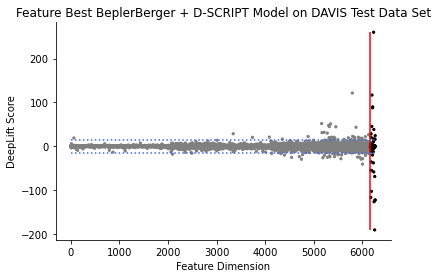

In [42]:
plt.scatter(np.arange(prot_feat._size), attr_trans,s=5,color=['gray' for i in range(prot_feat._size-100)]+['black' for i in range(100)])
plt.vlines(prot_feat._size-100,attr_trans.min(), attr_trans.max(),color='r')
plt.hlines(attr_trans.mean() + 2*attr_trans.std(),0,prot_feat._size,color='royalblue',linestyles='dotted')
plt.hlines(attr_trans.mean() - 2*attr_trans.std(),0,prot_feat._size,color='royalblue',linestyles='dotted')
plt.xlabel('Feature Dimension')
plt.ylabel('DeepLift Score')
plt.title('Feature Best BeplerBerger + D-SCRIPT Model on DAVIS Test Data Set')
sns.despine()
# plt.savefig('esm_dscript_cat_bindingdb_deeplift_attributions.svg')
plt.show()